<a href="https://colab.research.google.com/github/malloyca/steelpan-pitch/blob/main/onset-pitch/steelpan_onset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steelpan Onset-based Pitch Detection

For 183rd Meeting of the Acoustical Society of America, December 8, 2022.

## Todo

- Set up associated .csv file to store the performance based on `frame_length` and `hop_size` using pandas
- Create chart of estimation data
- Create a histogram of error amounts for each method (rounded to nearest MIDI integer / pitch class)
  - This will give us insight into the kind of errors each method is making

In [1]:
!pip install crepe
import crepe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 323 kB 12.9 MB/s 
     |████████████████████████████████| 217 kB 66.8 MB/s 
  Created wheel for crepe: filename=crepe-0.0.13-py3-none-any.whl size=134848712 sha256=46b69604433795108147f8d31d88999a36fe75282c595cd7e570c8e192a4afad
  Stored in directory: /root/.cache/pip/wheels/d8/68/be/b163712f8f71a6939dbaf4c26bbda6612a1e609b795af7a15e
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320730 sha256=b7b65adca574fbbf007b1d8def1eb32f07517fb66dd5f7a7147a89748ed97851
  Stored in directory: /root/.cache/pip/wheels/6f/d1/5d/f13da53b1dcbc2624ff548456c9ffb526c914f53c12c318bb4
Successfully built crepe resampy
  Attempting uninstall: resampy
    Found existing installation: resampy 0.4.2
    Uninstalling resampy-0.4.2:
      Successfully uninstalled resampy-0.4.2


In [2]:
!pip install essentia
import essentia.standard as es

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.6 MB 12.6 MB/s 


In [3]:
# imports
import os
from os import walk
import numpy as np
from numpy.lib.stride_tricks import as_strided
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from librosa import display

print(f"TensorFlow version: {tf.__version__}")

physical_devices = tf.config.list_physical_devices()
print(physical_devices)

TensorFlow version: 2.9.2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# download the tiny SASSE dataset # TODO: update dataset to newer version
!gdown "1hRfdF0ko2ItGK0y9z4xU_7VQLgRIx4Ql&confirm=t"
!unzip -u -qq '/content/SASSE_tiny_16.zip'

Downloading...
From: https://drive.google.com/uc?id=1hRfdF0ko2ItGK0y9z4xU_7VQLgRIx4Ql&confirm=t
To: /content/SASSE_tiny_16.zip
100% 40.9M/40.9M [00:00<00:00, 76.9MB/s]


In [6]:
# download the SASSE-16k dataset
!gdown "11volHbUTp1X0NyrtiEgjRtgwivwaw1Bs&confirm=t"
!unzip -u -qq '/content/SASSE_16.zip'

Downloading...
From: https://drive.google.com/uc?id=11volHbUTp1X0NyrtiEgjRtgwivwaw1Bs&confirm=t
To: /content/SASSE_16.zip
100% 443M/443M [00:04<00:00, 102MB/s]


In [7]:
# download the SASSE-48k dataset
!gdown "1U3IfVjQ_xCc7ZqVZpR9oPNAtPfA26CKs&confirm=t"
!unzip -u -qq '/content/SASSE_48.zip'

Downloading...
From: https://drive.google.com/uc?id=1U3IfVjQ_xCc7ZqVZpR9oPNAtPfA26CKs&confirm=t
To: /content/SASSE_48.zip
100% 1.10G/1.10G [00:11<00:00, 93.4MB/s]


# Steelpan Note Transients

Let's begin by examining the attack transients of a few steelpan samples.

In [8]:
frame_length = 2048
sr = 22050
attack_time = es.LogAttackTime(sampleRate=sr, startAttackThreshold=0.1, stopAttackThreshold=0.95)

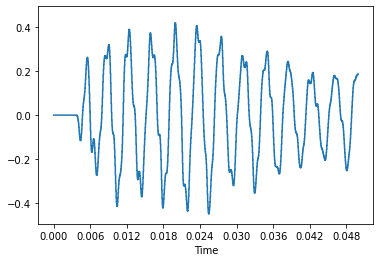

In [9]:
audio_01, sr = librosa.load('/content/SASSE_48/validation/60_valid_sample_7.wav')

lat, attack_start, attack_stop = attack_time(audio_01)
start, stop = int(sr * attack_start), int(sr * attack_stop)

#plot first 50 ms
fig, ax = plt.subplots()
librosa.display.waveshow(audio_01[:int(0.05*sr)], sr=sr, ax=ax)
plt.show()

Attack length: 15.011338517069817 ms
Number of samples: 331


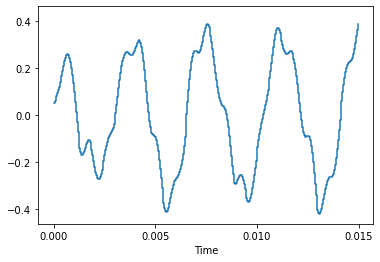

In [10]:
print(f"Attack length: {(attack_stop - attack_start) * 1000} ms")
print(f"Number of samples: {int((attack_stop - attack_start)*sr)}")
fig, ax = plt.subplots()
librosa.display.waveshow(audio_01[int(attack_start * sr) : int(attack_stop * sr)])
plt.show()

In [11]:
audio = audio_01

yin_out = librosa.yin(audio[:frame_length], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
yin_out = librosa.hz_to_midi(yin_out)
print("Yin pitch estimations")
print(f"50 ms: {np.round(yin_out,2)}")

yin_out = librosa.yin(audio[start:stop], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
yin_out = librosa.hz_to_midi(yin_out)
print(f"attack predictions: {np.round(yin_out, 2)}")

Yin pitch estimations
50 ms: [60.68 60.91 60.68 60.43 60.42]
attack predictions: [48.3]


In [12]:
audio = audio_01

pyin_out, _, _ = librosa.pyin(audio[:frame_length], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
pyin_out = librosa.hz_to_midi(pyin_out)
print("pYin pitch estimations")
print(f"50ms: {pyin_out}")

pyin_out, _, _ = librosa.pyin(audio[start:stop], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
pyin_out = librosa.hz_to_midi(pyin_out)
print(f"attack: {pyin_out}")

pYin pitch estimations
50ms: [ nan 60.9 60.7 60.4 60.4]
attack: [nan]


In [13]:
audio = audio_01

time, crepe_pred, _, _ = crepe.predict(audio, sr, viterbi=True)
crepe_pred = librosa.hz_to_midi(crepe_pred)
print("Crepe pitch estimations")
print(f"50 ms: {np.round(crepe_pred,2)}")

time, crepe_pred, _, _ = crepe.predict(audio[start:stop], sr, viterbi=True)
crepe_pred = librosa.hz_to_midi(crepe_pred)
print(f"attack: {np.round(crepe_pred,2)}")

8/8 [==============================] - 10s 1s/step
Crepe pitch estimations
50 ms: [60.65 60.51 60.46 60.42 60.32 60.36 60.46 60.46 60.4  60.27 60.18 60.16
 60.14 60.12 60.14 60.15 60.14 60.12 60.09 60.08 60.09 60.11 60.13 60.13
 60.12 60.09 60.09 60.09 60.11 60.11 60.11 60.11 60.09 60.06 60.07 60.09
 60.09 60.09 60.08 60.08 60.07 60.08 60.08 60.1  60.08 60.08 60.07 60.07
 60.08 60.09 60.1  60.09 60.08 60.07 60.07 60.07 60.11 60.12 60.12 60.1
 60.08 60.08 60.08 60.08 60.09 60.08 60.06 60.07 60.07 60.08 60.08 60.08
 60.07 60.07 60.06 60.07 60.08 60.09 60.07 60.06 60.07 60.07 60.06 60.08
 60.08 60.07 60.06 60.06 60.07 60.08 60.07 60.06 60.07 60.06 60.07 60.08
 60.1  60.08 60.07 60.07 60.07 60.07 60.09 60.09 60.1  60.07 60.06 60.07
 60.09 60.08 60.09 60.08 60.07 60.09 60.1  60.1  60.08 60.07 60.07 60.08
 60.07 60.09 60.08 60.07 60.07 60.07 60.06 60.06 60.07 60.1  60.08 60.07
 60.07 60.07 60.09 60.09 60.06 60.07 60.08 60.1  60.1  60.09 60.1  60.09
 60.07 60.07 60.07 60.07 60.1  60.12 60.11 

### What this shows

What the tests show for performing this on just the attack portion as determined by Essentia is that accuracy on such a small section is difficult and the algorithms clearly rely on longer contexts for accuracy.

8/8 [==============================] - 12s 1s/step
50 ms: [55.62 55.53 54.5  53.96 53.08 52.62 52.06 51.4  50.87 50.03 48.38 47.3
 47.77 47.66 47.98 47.92 47.78 47.63 49.17 50.85 51.99 53.65 54.85 54.88
 54.93 54.88 54.92 55.02 56.5  56.3  56.66 57.98 59.65 59.88 59.72 59.46
 59.37 59.81 60.16 60.17 60.15 60.07 60.28 60.01 59.71 59.79 59.91 60.01
 60.08 60.07 60.02 60.03 59.99 60.06 60.02 59.98 60.08 60.12 60.08 60.01
 59.98 60.01 60.02 60.   59.95 60.1  60.27 60.36 60.27 60.09 60.01 59.98
 60.03 60.05 60.11 60.15 60.11 60.11 60.08 60.07 60.04 60.02 60.04 60.07
 60.09 60.11 60.1  60.07 60.05 60.06 60.06 60.07 60.07 60.07 60.08 60.08
 60.07 60.06 60.05 60.07 60.06 60.05 60.05 60.06 60.07 60.08 60.06 60.05
 60.04 60.05 60.06 60.06 60.07 60.07 60.07 60.07 60.06 60.04 60.08 60.08
 60.1  60.08 60.08 60.06 60.08 60.06 60.08 60.06 60.06 60.05 60.06 60.07
 60.07 60.06 60.06 60.05 60.05 60.06 60.07 60.06 60.06 60.05 60.06 60.05
 60.06 60.06 60.05 60.05 60.05 60.05 60.06 60.06 60.06 60.06 60.05 

/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:200: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  "on a non-contiguous input. This will result in a copy.".format(axis)


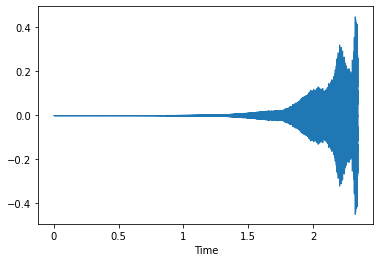

In [ ]:
audio_rev = audio[::-1]

time, crepe_pred, _, _ = crepe.predict(audio_rev, sr, viterbi=True)
crepe_pred = librosa.hz_to_midi(crepe_pred)
print(f"50 ms: {np.round(crepe_pred,2)}")

#plot first 50 ms
fig, ax = plt.subplots()
librosa.display.waveshow(audio_rev, sr=sr, ax=ax)
plt.show()

### Thoughts on bi-directional analysis

Interestingly, what this cell shows is that doing pitch detection in reverse gives different results. My intuition is that this could be caused by one of two things:
1. You are just catching the audio at different points. This would be similar to changing the start point of the analysis.
  - I'm leaning against this, however, since you'd think that the results would still be similar. The beginnings and endings of the two prediction arrays vary quite a bit, however. This leads me to my second hypothesis:
2. That since this is probabilistic (it uses the Viterbi algorithm) - and thus dependent on previous predictions - the direction of the processing affects the output values. The question then becomes, can we improve pitch detection results by performing bi-directional analysis?
  - An initial test of this would be to analyze an annotated dataset both forwards and backwards and then combining/averaging that data somehow. Another intersting approach would be to build a pitch detection architecture that does the bi-directional analysis by default.
  - The unfortunate limitation of this method would be that it really only works for offline analysis.

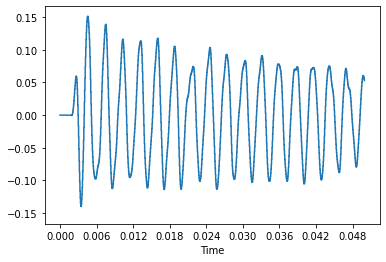

In [ ]:
audio_02, sr = librosa.load('/content/SASSE_48/validation/65_valid_sample_33.wav')

#plot first 50 ms
fig, ax = plt.subplots()
librosa.display.waveshow(audio_02[:int(0.05*sr)], sr=sr, ax=ax)
plt.show()

In [ ]:
yin_out = librosa.yin(audio_02[:frame_length], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
yin_out = librosa.hz_to_midi(yin_out)
print(np.round(yin_out,2))

[65.26 65.33 65.25 65.1  65.01]


In [ ]:
pyin_out, _, _ = librosa.pyin(audio_02[:frame_length], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
pyin_out = librosa.hz_to_midi(pyin_out)
print(pyin_out)

[ nan 65.3 65.2 65.1 65. ]


In [ ]:
time, crepe_pred, _, _ = crepe.predict(audio_02[:frame_length], sr, viterbi=True)
crepe_pred = librosa.hz_to_midi(crepe_pred)
print(np.round(crepe_pred,2))

1/1 [==============================] - 0s 354ms/step
[65.04 65.02 65.07 65.04 64.99 65.01 65.01 65.   65.   64.98]


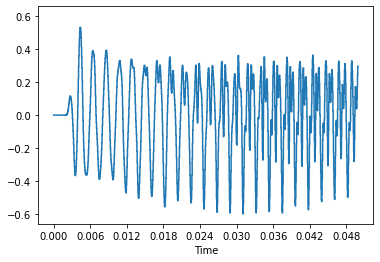

In [ ]:
audio_03, sr = librosa.load('/content/SASSE_48/validation/70_valid_sample_86.wav')

#plot first 50 ms
fig, ax = plt.subplots()
librosa.display.waveshow(audio_03[:int(0.05*sr)], sr=sr, ax=ax)
plt.show()

In [ ]:
yin_out = librosa.yin(audio_03[:frame_length], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
yin_out = librosa.hz_to_midi(yin_out)
print(np.round(yin_out,2))

[70.06 70.17 70.06 70.05 70.06]


In [ ]:
pyin_out, _, _ = librosa.pyin(audio_03[:frame_length], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
pyin_out = librosa.hz_to_midi(pyin_out)
print(pyin_out)

[ nan 70.2 70.1 70.  70.1]


In [ ]:
time, crepe_pred, _, _ = crepe.predict(audio_03[:frame_length], sr, viterbi=True)
crepe_pred = librosa.hz_to_midi(crepe_pred)
print(np.round(crepe_pred,2))

1/1 [==============================] - 0s 359ms/step
[70.07 70.03 70.03 70.05 70.04 70.05 70.05 70.03 70.   70.  ]


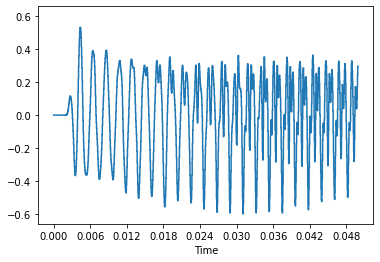

In [ ]:
audio_04, sr = librosa.load('/content/SASSE_48/validation/71_valid_sample_19.wav')

#plot first 50 ms
fig, ax = plt.subplots()
librosa.display.waveshow(audio_03[:int(0.05*sr)], sr=sr, ax=ax)
plt.show()

In [ ]:
yin_out = librosa.yin(audio_04[:frame_length], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
yin_out = librosa.hz_to_midi(yin_out)
print(np.round(yin_out,2))

[71.15 71.26 71.14 71.06 71.07]


In [ ]:
pyin_out, _, _ = librosa.pyin(audio_04[:frame_length], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
pyin_out = librosa.hz_to_midi(pyin_out)
print(pyin_out)

[ nan 71.3 71.1 71.1 71.1]


In [ ]:
time, crepe_pred, _, _ = crepe.predict(audio_04[:frame_length], sr, viterbi=True)
crepe_pred = librosa.hz_to_midi(crepe_pred)
print(np.round(crepe_pred,2))

1/1 [==============================] - 0s 369ms/step
[71.24 71.13 71.11 71.08 71.06 71.06 71.04 71.03 71.02 71.03]


# Evaluating Yin, pYin, and CRéPE

In [14]:
# prep
csv_path = '/content/drive/MyDrive/Research Projects/Steelpan pitch detection/onset-pitch/onset-pitch_evaluation.csv'
evaluation_df = pd.read_csv(csv_path)

In [15]:
evaluation_df.head()

,Dataset,Algorithm,samplerate,frame length,hop size,50 cent accuracy,25 cent accuracy,10 cent accuracy,frames analyzed


## YIN evaluation

In [59]:
def get_yin_estimation(sample_path, samplerate, target, frame_size, hop_size,
                       attack_length=0.05):
  
  # load sample
  loader = es.MonoLoader(filename=sample_path, sampleRate=samplerate)
  audio = loader()

  # trim the sample to the first 50 ms
  start_stop = es.StartStopSilence(threshold=-60)
  start_frame, stop_frame = 0, 0
  for frame in es.FrameGenerator(audio, frame_size, hop_size):
    start_frame, stop_frame = start_stop(frame)

  start_time = float(start_frame * hop_size) / float(samplerate)
  frame_length = frame_size / samplerate
  end_time = start_time + attack_length #+ frame_length # pad the attack length by frame_length
  
  # trim audio
  trimmer = es.Trimmer(startTime=start_time, endTime=end_time,
                       sampleRate=samplerate)
  trimmed_audio = trimmer(audio)

  # get yin pitch estimations
  pitch_estimations = librosa.yin(trimmed_audio, fmin=librosa.note_to_hz('C2'),
                                  fmax=librosa.note_to_hz('C7'), sr=samplerate,
                                  frame_length=frame_size, hop_length=hop_size)
  
  # filter out NaNs
  pitch_estimations = pitch_estimations[~np.isnan(pitch_estimations)]

  # populate array of target values to match size of estimations array
  targets = [float(target)] * pitch_estimations.shape[0]

  return pitch_estimations, targets

In [60]:
# test to make sure it's working
get_yin_estimation('/content/SASSE_tiny_16/train/60_train_sample_101.wav',
                   samplerate=16000, target=60, frame_size=1024, hop_size=512)

(array([261.16396013, 261.54450673]), [60.0, 60.0])

In [62]:
def process_folder_yin(directory, samplerate, frame_size, hop_size,
                        attack_length=0.05):
  folder_pitches = []
  folder_targets = []
  file_count = 0
  count = 0

  for (dir_path, _, filenames) in os.walk(directory):
    num_files = len(filenames)
    for filename in filenames:
      file_path = os.path.join(dir_path, filename)

      # in my formatting, the target is given by the first numbers in the filename
      target = filename.split("_")[0]
      pitches, targets = get_yin_estimation(file_path, samplerate=samplerate,
                                            target=target,
                                            frame_size=frame_size,
                                            hop_size=hop_size,
                                            attack_length=attack_length)
      
      folder_pitches.append(pitches)
      folder_targets.append(targets)

      file_count += 1
      print(f'Progress: {file_count}/{num_files}')

  folder_pitches = np.concatenate(folder_pitches)
  folder_targets = np.concatenate(folder_targets)
  print(f"Num files processed: {file_count}")
  return folder_pitches, folder_targets

In [91]:
yin_estimates, yin_targets = process_folder_yin('/content/SASSE_tiny_16/validation', samplerate=16000,
                                                frame_size=128, hop_size=64,
                                                attack_length=0.02)

Progress: 1/300
Progress: 2/300
Progress: 3/300
Progress: 4/300
Progress: 5/300
Progress: 6/300
Progress: 7/300
Progress: 8/300
Progress: 9/300
Progress: 10/300
Progress: 11/300
Progress: 12/300
Progress: 13/300
Progress: 14/300
Progress: 15/300
Progress: 16/300
Progress: 17/300
Progress: 18/300
Progress: 19/300
Progress: 20/300
Progress: 21/300
Progress: 22/300
Progress: 23/300
Progress: 24/300
Progress: 25/300
Progress: 26/300
Progress: 27/300
Progress: 28/300
Progress: 29/300
Progress: 30/300
Progress: 31/300
Progress: 32/300
Progress: 33/300
Progress: 34/300
Progress: 35/300
Progress: 36/300
Progress: 37/300
Progress: 38/300
Progress: 39/300
Progress: 40/300
Progress: 41/300
Progress: 42/300
Progress: 43/300
Progress: 44/300
Progress: 45/300
Progress: 46/300
Progress: 47/300
Progress: 48/300
Progress: 49/300
Progress: 50/300
Progress: 51/300
Progress: 52/300
Progress: 53/300
Progress: 54/300
Progress: 55/300
Progress: 56/300
Progress: 57/300
Progress: 58/300
Progress: 59/300
Progre

In [92]:
print(yin_estimates.shape, yin_targets.shape)

(1800,) (1800,)


In [93]:
yin_matches_50 = np.where(np.abs(librosa.hz_to_midi(yin_estimates) - yin_targets) < 0.5)
yin_matches_25 = np.where(np.abs(librosa.hz_to_midi(yin_estimates) - yin_targets) < 0.25)
yin_matches_10 = np.where(np.abs(librosa.hz_to_midi(yin_estimates) - yin_targets) < 0.1)

In [94]:
print(f"50 cent accuracy: {yin_matches_50[0].shape[0] / len(yin_targets)}")
print(f"25 cent accuracy: {yin_matches_25[0].shape[0] / len(yin_targets)}")
print(f"10 cent accuracy: {yin_matches_10[0].shape[0] / len(yin_targets)}")

50 cent accuracy: 0.4388888888888889
25 cent accuracy: 0.3005555555555556
10 cent accuracy: 0.1411111111111111


## pYin evaluation

In [75]:
def get_pyin_estimation(sample_path, samplerate, target, frame_size, hop_size,
                        attack_length=0.05):

  # load sample
  loader = es.MonoLoader(filename=sample_path, sampleRate=samplerate)
  audio = loader()

  # trim the sample to the first 50 ms
  start_stop = es.StartStopSilence(threshold=-60)
  start_frame, stop_frame = 0, 0
  for frame in es.FrameGenerator(audio, frame_size, hop_size):
    start_frame, stop_frame = start_stop(frame)

  start_time = float(start_frame * hop_size) / float(samplerate)
  bonus_time = hop_size / samplerate
  end_time = start_time + attack_length + bonus_time

  # trim audio
  trimmer = es.Trimmer(startTime=start_time, endTime=end_time,
                       sampleRate=samplerate)
  trimmed_audio = trimmer(audio)

  # get pyin pitch estimations
  pitch_estimations, _, _ = librosa.pyin(trimmed_audio, fmin=librosa.note_to_hz('C2'),
                               fmax=librosa.note_to_hz('C7'), sr=samplerate,
                               frame_length=frame_size, hop_length=hop_size)
  
  # filter out NaNs
  pitch_estimations = pitch_estimations[~np.isnan(pitch_estimations)]
  
  # populate array of target values to match size of estimations array
  targets = [float(target)] * pitch_estimations.shape[0]

  return pitch_estimations, targets

In [76]:
# test to make sure it's working
get_pyin_estimation('/content/SASSE_tiny_16/train/60_train_sample_101.wav',
                   samplerate=16000, target=60, frame_size=1024, hop_size=512)

(array([261.6255653 , 263.14114678]), [60.0, 60.0])

In [77]:
def process_folder_pyin(directory, samplerate, frame_size, hop_size,
                        attack_length=0.05):
  folder_pitches = []
  folder_targets = []
  file_count = 0
  count = 0

  for (dir_path, _, filenames) in os.walk(directory):
    num_files = len(filenames)
    for filename in filenames:
      file_path = os.path.join(dir_path, filename)

      # in my formatting, the target is given by the first numbers in the filename
      target = filename.split("_")[0]
      pitches, targets = get_pyin_estimation(file_path, samplerate=samplerate,
                                             target=target,
                                             frame_size=frame_size,
                                             hop_size=hop_size,
                                             attack_length=attack_length)
      
      folder_pitches.append(pitches)
      folder_targets.append(targets)

      file_count += 1
      print(f'Progress: {file_count}/{num_files}')

  folder_pitches = np.concatenate(folder_pitches)
  folder_targets = np.concatenate(folder_targets)
  print(f"Num files processed: {file_count}")
  return folder_pitches, folder_targets

In [87]:
pyin_estimates, pyin_targets = process_folder_pyin('/content/SASSE_tiny_16/validation', samplerate=16000,
                                                   frame_size=256, hop_size=128,
                                                   attack_length=0.02)

Progress: 1/300
Progress: 2/300
Progress: 3/300
Progress: 4/300
Progress: 5/300
Progress: 6/300
Progress: 7/300
Progress: 8/300
Progress: 9/300
Progress: 10/300
Progress: 11/300
Progress: 12/300
Progress: 13/300
Progress: 14/300
Progress: 15/300
Progress: 16/300
Progress: 17/300
Progress: 18/300
Progress: 19/300
Progress: 20/300
Progress: 21/300
Progress: 22/300
Progress: 23/300
Progress: 24/300
Progress: 25/300
Progress: 26/300
Progress: 27/300
Progress: 28/300
Progress: 29/300
Progress: 30/300
Progress: 31/300
Progress: 32/300
Progress: 33/300
Progress: 34/300
Progress: 35/300
Progress: 36/300
Progress: 37/300
Progress: 38/300
Progress: 39/300
Progress: 40/300
Progress: 41/300
Progress: 42/300
Progress: 43/300
Progress: 44/300
Progress: 45/300
Progress: 46/300
Progress: 47/300
Progress: 48/300
Progress: 49/300
Progress: 50/300
Progress: 51/300
Progress: 52/300
Progress: 53/300
Progress: 54/300
Progress: 55/300
Progress: 56/300
Progress: 57/300
Progress: 58/300
Progress: 59/300
Progre

In [88]:
print(pyin_estimates.shape, pyin_targets.shape)

(792,) (792,)


In [89]:
pyin_matches_50 = np.where(np.abs(librosa.hz_to_midi(pyin_estimates) - pyin_targets) < 0.5)
pyin_matches_25 = np.where(np.abs(librosa.hz_to_midi(pyin_estimates) - pyin_targets) < 0.25)
pyin_matches_10 = np.where(np.abs(librosa.hz_to_midi(pyin_estimates) - pyin_targets) < 0.1)

In [90]:
print(f"50 cent accuracy: {pyin_matches_50[0].shape[0] / len(pyin_targets)}")
print(f"25 cent accuracy: {pyin_matches_25[0].shape[0] / len(pyin_targets)}")
print(f"10 cent accuracy: {pyin_matches_10[0].shape[0] / len(pyin_targets)}")

50 cent accuracy: 0.797979797979798
25 cent accuracy: 0.6224747474747475
10 cent accuracy: 0.3939393939393939


## CRéPE Evaluation

In [97]:
def get_crepe_estimation(sample_path, samplerate, target, frame_size, hop_size,
                         attack_length=0.05, model_capacity='full', viterbi=False,
                         step_size=10):

  # load sample
  loader = es.MonoLoader(filename=sample_path, sampleRate=samplerate)
  audio = loader()

  # trim the sample to the first 50 ms
  start_stop = es.StartStopSilence(threshold=-60)
  start_frame, stop_frame = 0, 0
  for frame in es.FrameGenerator(audio, frame_size, hop_size):
    start_frame, stop_frame = start_stop(frame)

  start_time = float(start_frame * hop_size) / float(samplerate)
  end_time = start_time + attack_length

  # trim audio
  trimmer = es.Trimmer(startTime=start_time, endTime=end_time,
                       sampleRate=samplerate)
  trimmed_audio = trimmer(audio)

  # get crepe pitch estimations
  times, crepe_pred, _, _ = crepe.predict(trimmed_audio, sr=samplerate,
                                          model_capacity=model_capacity,
                                          viterbi=viterbi, step_size=step_size)
  
  # filter out NaNs
  crepe_pred = crepe_pred[~np.isnan(crepe_pred)]
  
  # populate array of target values to match size of estimations array
  targets = [float(target)] * crepe_pred.shape[0]

  return crepe_pred, targets

In [117]:
def process_folder_crepe(directory, samplerate, frame_size, hop_size,
                         attack_length=0.05, model_capacity='full', viterbi=False,
                         step_size=10):
  folder_pitches = []
  folder_targets = []
  file_count = 0
  count = 0

  for (dir_path, _, filenames) in os.walk(directory):
    num_files = len(filenames)
    for filename in filenames:
      file_path = os.path.join(dir_path, filename)

      # in my formatting, the target is given by the first numbers in the filename
      target = filename.split("_")[0]
      pitches, targets = get_crepe_estimation(file_path, samplerate=samplerate,
                                              target=target,
                                              frame_size=frame_size,
                                              hop_size=hop_size,
                                              attack_length=attack_length,
                                              viterbi=viterbi,
                                              step_size=step_size)
      
      folder_pitches.append(pitches)
      folder_targets.append(targets)

      file_count += 1
      print(f'Progress: {file_count}/{num_files}')

  folder_pitches = np.concatenate(folder_pitches)
  folder_targets = np.concatenate(folder_targets)
  print(f"Num files processed: {file_count}")
  return folder_pitches, folder_targets

In [118]:
crepe_estimates, crepe_targets = process_folder_crepe('/content/SASSE_tiny_16/validation',
                                                      samplerate=16000,
                                                      frame_size=256,
                                                      hop_size=128,
                                                      attack_length=0.02,
                                                      model_capacity='full',
                                                      viterbi=False,
                                                      step_size=10)

1/1 [==============================] - 0s 158ms/step
Progress: 1/300
1/1 [==============================] - 0s 155ms/step
Progress: 2/300
1/1 [==============================] - 0s 153ms/step
Progress: 3/300
1/1 [==============================] - 0s 149ms/step
Progress: 4/300
1/1 [==============================] - 0s 150ms/step
Progress: 5/300
1/1 [==============================] - 0s 146ms/step
Progress: 6/300
1/1 [==============================] - 0s 154ms/step
Progress: 7/300
1/1 [==============================] - 0s 146ms/step
Progress: 8/300
1/1 [==============================] - 0s 140ms/step
Progress: 9/300
1/1 [==============================] - 0s 158ms/step
Progress: 10/300
1/1 [==============================] - 0s 140ms/step
Progress: 11/300
1/1 [==============================] - 0s 158ms/step
Progress: 12/300
1/1 [==============================] - 0s 144ms/step
Progress: 13/300
1/1 [==============================] - 0s 141ms/step
Progress: 14/300
1/1 [========================

In [119]:
print(crepe_estimates.shape, crepe_targets.shape)

(900,) (900,)


In [120]:
crepe_matches_50 = np.where(np.abs(librosa.hz_to_midi(crepe_estimates) - crepe_targets) < 0.5)
crepe_matches_25 = np.where(np.abs(librosa.hz_to_midi(crepe_estimates) - crepe_targets) < 0.25)
crepe_matches_10 = np.where(np.abs(librosa.hz_to_midi(crepe_estimates) - crepe_targets) < 0.1)

In [121]:
print(f"50 cent accuracy: {crepe_matches_50[0].shape[0] / len(crepe_targets)}")
print(f"25 cent accuracy: {crepe_matches_25[0].shape[0] / len(crepe_targets)}")
print(f"10 cent accuracy: {crepe_matches_10[0].shape[0] / len(crepe_targets)}")

50 cent accuracy: 0.7422222222222222
25 cent accuracy: 0.6133333333333333
10 cent accuracy: 0.3688888888888889


# CRéPE-style network

## Model Builder

In [122]:
models = {
    'tiny': None,
    'small': None,
    'medium': None,
    'large': None,
    'full': None
}

# the model is trained on 16 kHz audio for now # TODO: upgrade to a higher samplerate
model_samplerate = 1600

def make_model(model_capacity, metrics, weights=None):
  '''
  model_capacity: tiny, small, medium, large, full
  weights: path of .h5 weight file
  '''

  from tensorflow.keras.layers import Input, Reshape, Conv2D, BatchNormalization
  from tensorflow.keras.layers import MaxPool2D, Dropout, Permute, Flatten, Dense
  from tensorflow.keras.models import Model

  capacity_multiplier = {
      'tiny': 4, 'small': 8, 'medium': 16, 'large': 24, 'full': 32
  }[model_capacity]

  layers = [1, 2, 3, 4, 5, 6]
  filters = [n * capacity_multiplier for n in [32, 4, 4, 4, 8, 16]]
  widths = [512, 64, 64, 64, 64, 64]
  strides = [(4,1), (1,1), (1,1), (1,1), (1,1), (1,1)]

  x = Input(shape=(1024,), name='input', dtype='float32')
  y = Reshape(target_shape=(1024, 1, 1), name='input-reshape')(x)

  for l, f, w, s in zip(layers, filters, widths, strides):
    y = Conv2D(f, (w, 1), strides=s, padding='same',
               activation='relu', name="conv%d" % l)(y)
    y = BatchNormalization(name="conv%d-BN" % l)(y)
    y = MaxPool2D(pool_size=(2, 1), strides=None, padding='valid',
                  name="conv%d-maxpool" % l)(y)
    y = Dropout(0.25, name="conv%d-dropout" % l)(y)

  y = Permute((2, 1, 3), name="transpose")(y)
  y = Flatten(name="flatten")(y)
  y = Dense(360, activation='sigmoid', name="classifier")(y)

  model = Model(inputs=x, outputs=y)

  if weights != None:
    model.load_weights(weights)
  model.compile(tf.keras.optimizers.Adam(learning_rate=0.0002),
                'binary_crossentropy', metrics=metrics)
  
  models[model_capacity] = model

  return model

In [124]:
# todo - Just use Librosa's db_to_power instead?
def db_to_pow(db):
  '''Convert from dB to power'''
  return 10**(db / 10)


def frame_energy(frame):
  '''Calculates the average energy for a frame
    
    Parameters
    ----------
    frame : np.array
      audio frame in np.float32 format

    Returns
    -------
    average_energy : float
      Average energy level for frame
  '''

  # Square the sample values to convert to energy values
  energy = frame**2

  # Sum the energy values to get total energy
  total_energy = np.sum(energy)

  # Divide by length to get average energy
  return total_energy / len(frame)

In [130]:
def process_audio_file(filepath, samplerate=16000, threshold_pow=1e-06,
                       frame_size=1024, step_size=5, onset=True,
                       onset_length=0.05):
  '''
  Processes a single audio file by formatting it into frames and extracting the label.
  
  Parameters
  ----------
  filepath : string
  Filepath for audio.

  threshold_pow : float
  Frames with average energy less than this are clipped.

  frame_size : int
  Number of samples per audio frame

  step_size : float
  Space between each frame (in milliseconds).

  onset : bool
  Flag to process only the onsets

  onset_length : float
  Amount of time to consider as the onset (s)

  Returns
  -------
  frames : np.array dtype=float
  The normalized and clipped audio, in frame form.

  labels : int[]
  The pitch of the audio file, in MIDI. It's duplicated
  because the model requires one label for each frame.
  '''

  '''loader = es.MonoLoader(filename=filepath, sampleRate=samplerate)
  audio = loader()

  # trim the audio to the first 50 ms
  start_stop = es.StartStopSilence(threshold=threshold_pow)
  start_frame, stop_frame = 0, 0
  for frame in es.FrameGenerator(audio, frame_size, step_size):
    start_frame, stop_frame = start_stop(frame)

  start_time = float(start_frame * step_size) / float(samplerate)
  end_time = start_time + onset_length

  # time audio
  trimmer = es.Trimmer(startTime=start_time, endTime=end_time)
  trimmed_audio = trimmer(audio)'''

  audio, _ = librosa.load(filepath, sr=samplerate)

  # Format the audio into frames for Crepe
  hop_length = int(samplerate * step_size / 1000)
  n_frames = 1 + int((len(audio) - 1024) / hop_length)
  frames = as_strided(audio, shape=(1024, n_frames),
                      strides=(audio.itemsize, hop_length * audio.itemsize))
  frames = frames.transpose().copy()

  # Find the first frame where the levels meet threshold_pow
  for f in range(len(frames)):
    if frame_energy(frames[f]) > threshold_pow:
      start_frame = f
      break
  
  if onset:
    end_frame = f + int(onset_length * 1000 / step_size)
  else:
    for f in range(len(frames) - 1, -1, -1):
      if frame_energy(frames[f]) > threshold_pow:
        end_frame = f + 1
        break

  frames = frames[start_frame:end_frame]

  # Normalize each frame
  frames -= np.mean(frames, axis=1)[:, np.newaxis]
  frames /= np.std(frames, axis=1)[:, np.newaxis]

  # Prep labels
  labels = [int(os.path.basename(filepath).split("_")[0]) for _ in range(end_frame - start_frame)]

  return frames, labels

In [132]:
f, l = process_audio_file('/content/SASSE_tiny_16/train/60_train_sample_101.wav', step_size=2)
print(len(l))

25


In [133]:
def load_audio_batch(dir, samplerate=16000, threshold_db=-60, step_size=5,
                     onset=True, onset_length=0.05, blur=True):
  '''
    Loads and processes all audio files from a directory, returning a single
    array of audio frames and labels. Will load audio from nested dirs as well.

    Parameters
    ----------
    dir : string
    Starting dirpath to load audio from.

    threshold_db : float
    Frames with average energy less than this are clipped (this is converted dB -> power first).

    Returns
    -------
    frames_list : np.array dtype=float
    Audio frames from all loaded audio files.

    labels_list : np.array dtype=float
    The labels for the model. It is formatted as a one-hot vector
    with Gaussian blur applied, so indices closer to the correct
    index are closer to 1 (e.g. if the correct index is 200 then
    index 198 might be 0.953 but index 50 might be 0.067).
  '''

  frames_list = []
  labels_list = []
  threshold_pow = db_to_pow(threshold_db)

  for (dirpath, _, filenames) in walk(dir):
    for filename in filenames:
      frames, labels = process_audio_file(dirpath + "/" + filename,
                                          samplerate=samplerate,
                                          threshold_pow=threshold_pow,
                                          step_size=step_size, onset=onset,
                                          onset_length=onset_length)

      frames_list.append(frames)
      labels_list += labels

  # assemble frames from all files into one array
  frames_list = np.concatenate(frames_list)

  # convert MIDI to Crepe cents one-hot vector (0-360)
  with tf.device('/cpu:0'):
    lables_list = np.array(tf.one_hot(5 * (np.array(labels_list) - 24), 360))

  # apply Gaussian blur
  if blur:
    cents_i = np.arange(360)
    for i in range(len(labels_list)):
      cents_true = np.where(labels_list[i] == 1)[0][0]
      labels_list[i] = np.exp(-((20 *(cents_i - cents_true)) ** 2) / (2 * (25 ** 2)))

  return frames_list, labels_list

In [134]:
metrics = "Accuracy"
model = make_model('full', metrics=metrics)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1024)]            0         
                                                                 
 input-reshape (Reshape)     (None, 1024, 1, 1)        0         
                                                                 
 conv1 (Conv2D)              (None, 256, 1, 1024)      525312    
                                                                 
 conv1-BN (BatchNormalizatio  (None, 256, 1, 1024)     4096      
 n)                                                              
                                                                 
 conv1-maxpool (MaxPooling2D  (None, 128, 1, 1024)     0         
 )                                                               
                                                                 
 conv1-dropout (Dropout)     (None, 128, 1, 1024)      0   